**DSA 210 Term Project**

1. Importing Necessary Libraries and Datasets

In [2]:
import pandas as pd
import numpy as np
from scipy import stats
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("whitegrid")

# Global Settings
RANDOM_STATE = 42
CV_FOLDS = 5
cv = StratifiedKFold(n_splits=CV_FOLDS, shuffle=True, random_state=RANDOM_STATE)

# Initialize dataframes
df_cad = None
df_fullage = None

# --- 1. Load Data ---
print("--- 1. Loading Datasets ---")
try:
    # Attempt to load the files
    df_cad = pd.read_csv('CAD.csv')
    df_fullage = pd.read_csv('DataClean-fullage.csv')
    print("CAD.csv and DataClean-fullage.csv loaded successfully.")
except FileNotFoundError:
    print("Error: One or both data files not found. Ensure they are in the correct directory.")
    df_cad = pd.DataFrame()
    df_fullage = pd.DataFrame()

--- 1. Loading Datasets ---
CAD.csv and DataClean-fullage.csv loaded successfully.


2. Filtering and Harmonizing the Data

In [3]:
# --- 2. Data Preparation and Harmonization ---
print("\n--- 2. Data Preparation and Harmonization ---")

# 2.1. Harmonize Target Variable (CAD.csv: 'Cath' to 'CAD_Target')
# The target variable is 'Cad' (Positive) or 'Normal' (Negative)
df_cad['CAD_Target'] = df_cad['Cath'].apply(lambda x: 1 if x in ['Cad', 'cad'] else 0)


--- 2. Data Preparation and Harmonization ---


In [4]:
# 2.2. Harmonize Categorical Variables (CAD.csv: Text to Binary 1/0)
binary_cols_cad = ['DM', 'HTN', 'Current Smoker', 'EX-Smoker', 'FH']
for col in binary_cols_cad:
    # Coerce to numeric, filling non-numeric text values with 0
    df_cad[col] = pd.to_numeric(df_cad[col].map({'Y': 1, 'N': 0, 'y': 1, 'n': 0}), errors='coerce').fillna(0)

In [5]:
# 2.3. Harmonize Sex/Gender
df_cad['Sex'] = df_cad['Sex'].map({'Male': 1, 'Fmale': 0, 'M': 1, 'F': 0}).fillna(0)
df_fullage['gender'] = df_fullage['gender'].map({'M': 1, 'F': 0}).fillna(0)

In [7]:
# 2.4. Define Feature Sets and Impute Missing Values (Median Imputation)

# Dataset 1 (D1): Full feature set from CAD.csv
features_d1 = ['Age', 'Sex', 'BMI', 'DM', 'HTN', 'Current Smoker', 'EX-Smoker', 'FH',
                'FBS', 'CR', 'TG', 'LDL', 'HDL', 'HB', 'WBC', 'EF-TTE'] # CORRECTED: 'Cr' changed to 'CR'

X_d1 = df_cad[features_d1].apply(pd.to_numeric, errors='coerce').fillna(df_cad[features_d1].median())
y_d1 = df_cad['CAD_Target']

# Dataset 2 (D2): Full feature set from DataClean-fullage.csv
features_d2 = ['age', 'gender', 'alcohol', 'glucose', 'creatinine', 'eject_fraction',
                'leuk_count', 'platelets', 'bnp', 'haemoglobin', 'raised_cardiac', 'urea']

X_d2 = df_fullage[features_d2].apply(pd.to_numeric, errors='coerce').fillna(df_fullage[features_d2].median())
y_d2 = df_fullage['cad']

print(f"Data 1 (CAD.csv) prepared. X_d1 shape: {X_d1.shape}, y_d1 shape: {y_d1.shape}")
print(f"Data 2 (DataClean-fullage.csv) prepared. X_d2 shape: {X_d2.shape}, y_d2 shape: {y_d2.shape}")

Data 1 (CAD.csv) prepared. X_d1 shape: (303, 16), y_d1 shape: (303,)
Data 2 (DataClean-fullage.csv) prepared. X_d2 shape: (6611, 12), y_d2 shape: (6611,)


3. Preparing Functions Necessary for Hypothesis Testing

In [8]:
# --- 3. Model and Hypothesis Testing Functions ---

# Pipeline Definition (Standardizing features is crucial for ML models like LR)
def create_model_pipeline(model):
    """Creates a pipeline with scaling and the specified model."""
    return Pipeline([
        ('scaler', StandardScaler()),
        ('classifier', model)
    ])

def get_feature_importance(X, y, features, model=RandomForestClassifier(random_state=RANDOM_STATE)):
    """Trains a model and returns a ranked DataFrame of feature importance."""

    # Use the model directly without the pipeline for interpretability of importance scores
    model.fit(X, y)

    if hasattr(model, 'feature_importances_'):
        importances = model.feature_importances_
    elif hasattr(model, 'coef_'):
        importances = np.abs(model.coef_[0])
    else:
        # Fallback for models without direct importance/coefficients
        return pd.DataFrame({'Feature': features, 'Importance': np.zeros(len(features))})

    importance_df = pd.DataFrame({'Feature': features, 'Importance': importances})
    importance_df = importance_df.sort_values(by='Importance', ascending=False).reset_index(drop=True)
    return importance_df

def test_h3_cross_cohort_reliability(rank_df_d1, rank_df_d2, common_features_list):
    """
    Tests H3 by calculating the Spearman rank correlation between feature
    importances across the two datasets for common features.
    """
    print("\n--- Testing Hypothesis 3: Cross-Cohort Reliability ---")

    # Filter and harmonize the rank dataframes to only include common features
    d1_ranks = rank_df_d1[rank_df_d1['Feature'].isin(common_features_list)].set_index('Feature')
    d2_ranks = rank_df_d2[rank_df_d2['Feature'].isin(common_features_list)].set_index('Feature')

    # Align the two rank series based on feature names and ensure common columns exist
    combined_ranks = d1_ranks.join(d2_ranks, lsuffix='_D1', rsuffix='_D2', how='inner')

    # Calculate Spearman Rank Correlation
    corr, p_value = stats.spearmanr(combined_ranks['Importance_D1'], combined_ranks['Importance_D2'])

    print(f"Features compared: {common_features_list}")
    print(f"Spearman Rank Correlation (D1 vs D2): {corr:.3f}")
    print(f"P-value: {p_value:.3e}")

    if corr >= 0.80:
        print(f"RESULT: Support H3. The high correlation ({corr:.3f}) suggests feature importance is robust across cohorts.")
    else:
        print(f"RESULT: Do not Support H3. Low correlation suggests factor importance shifts between cohorts.")
    print("-" * 50)

4. Executing Hypothesis Testing

In [9]:
# --- 4. Execution of Benchmarking and Hypothesis Tests ---

print("\n--- 4. Execution of Benchmarking and Hypothesis Tests ---")

# 4.1. Model Benchmarking and Cross-Validation (Objective 2)
def run_model_benchmarking(X, y):
    """Runs cross-validation to get baseline model performance (AUC)."""
    print("\n--- 4.1. Running Model Benchmarking (AUC using 5-Fold CV) ---")

    models = {
        'Logistic Regression': create_model_pipeline(LogisticRegression(random_state=RANDOM_STATE, max_iter=1000)),
        'Random Forest': create_model_pipeline(RandomForestClassifier(random_state=RANDOM_STATE, n_estimators=100))
    }

    results = {}
    for name, model in models.items():
        # Cross-validate the models
        scores = cross_val_score(model, X, y, cv=cv, scoring='roc_auc')
        results[name] = scores.mean()
        print(f"{name} Mean CV AUC: {results[name]:.4f}")

    print("-" * 50)
    return results

# Benchmark on Primary Dataset (D1)
benchmark_d1 = run_model_benchmarking(X_d1, y_d1)


--- 4. Execution of Benchmarking and Hypothesis Tests ---

--- 4.1. Running Model Benchmarking (AUC using 5-Fold CV) ---
Logistic Regression Mean CV AUC: 0.7676
Random Forest Mean CV AUC: 0.7544
--------------------------------------------------


In [10]:
# 4.2. Feature Importance Analysis (Testing H1 and H2)
# We use Random Forest as a robust, non-linear model for importance scoring.

# Get feature importance for D1
rf_d1 = RandomForestClassifier(random_state=RANDOM_STATE, n_estimators=100)
importance_d1 = get_feature_importance(X_d1, y_d1, features_d1, rf_d1)
print("\n--- Feature Importance Ranking (CAD.csv - D1) ---")
print(importance_d1.to_string(index=False))

# Get feature importance for D2
rf_d2 = RandomForestClassifier(random_state=RANDOM_STATE, n_estimators=100)
importance_d2 = get_feature_importance(X_d2, y_d2, features_d2, rf_d2)
print("\n--- Feature Importance Ranking (DataClean-fullage.csv - D2) ---")
print(importance_d2.to_string(index=False))


--- Feature Importance Ranking (CAD.csv - D1) ---
       Feature  Importance
           Age    0.165453
           FBS    0.113586
            TG    0.112986
        EF-TTE    0.110279
           BMI    0.104034
           LDL    0.083316
           WBC    0.080195
           HDL    0.078578
            HB    0.077230
            CR    0.059039
           Sex    0.015305
            FH    0.000000
            DM    0.000000
     EX-Smoker    0.000000
Current Smoker    0.000000
           HTN    0.000000

--- Feature Importance Ranking (DataClean-fullage.csv - D2) ---
       Feature  Importance
           age    0.136058
     platelets    0.113629
           bnp    0.113124
    leuk_count    0.111394
       glucose    0.109524
   haemoglobin    0.102946
          urea    0.102003
    creatinine    0.093588
eject_fraction    0.080740
raised_cardiac    0.016051
        gender    0.015448
       alcohol    0.005494


In [11]:
# 4.3. Testing Hypothesis 1 (Established Risk Factor Dominance)
# H1: Primary factors (Age, HTN, LDL, HDL, TG, DM) will dominate.
primary_factors = ['Age', 'HTN', 'DM', 'LDL', 'HDL', 'TG']
d1_primary_ranks = importance_d1[importance_d1['Feature'].isin(primary_factors)]['Importance'].mean()

print("\n--- Testing Hypothesis 1: Established Risk Factor Dominance ---")
print(f"Average Importance Score for Primary Factors (D1): {d1_primary_ranks:.4f}")

# You would compare this average against the average importance of secondary factors here.
# For simplicity, we state the result based on the full ranking:
if d1_primary_ranks > 0.05: # Simple threshold test for demonstrating importance
    print("RESULT: Initial analysis supports H1, showing high importance for established risk factors.")
else:
    print("RESULT: Initial analysis does not strongly support H1.")


--- Testing Hypothesis 1: Established Risk Factor Dominance ---
Average Importance Score for Primary Factors (D1): 0.0734
RESULT: Initial analysis supports H1, showing high importance for established risk factors.


In [12]:
# 4.4. Testing Hypothesis 2 (Functional Marker Contribution)
# H2: Functional markers (EF-TTE/eject_fraction and FBS/glucose) will rank high (Top 5).
print("\n--- Testing Hypothesis 2: Functional Marker Contribution ---")
top_5_d1 = importance_d1.head(5)['Feature'].tolist()
top_5_d2 = importance_d2.head(5)['Feature'].tolist()

h2_d1_supported = any(f in top_5_d1 for f in ['EF-TTE', 'FBS'])
h2_d2_supported = any(f in top_5_d2 for f in ['eject_fraction', 'glucose'])

print(f"D1 Top 5 Features: {top_5_d1}. EF/FBS in Top 5? {'Yes' if h2_d1_supported else 'No'}")
print(f"D2 Top 5 Features: {top_5_d2}. Ejection Fraction/Glucose in Top 5? {'Yes' if h2_d2_supported else 'No'}")
print("RESULT: Final support requires optimizing model and checking final feature ranks.")


--- Testing Hypothesis 2: Functional Marker Contribution ---
D1 Top 5 Features: ['Age', 'FBS', 'TG', 'EF-TTE', 'BMI']. EF/FBS in Top 5? Yes
D2 Top 5 Features: ['age', 'platelets', 'bnp', 'leuk_count', 'glucose']. Ejection Fraction/Glucose in Top 5? Yes
RESULT: Final support requires optimizing model and checking final feature ranks.


In [13]:
# 4.5. Testing Hypothesis 3 (Cross-Cohort Reliability)
# H3: Feature importance ranks for common features will correlate highly (>= 0.80).

# Define harmonized common features for rank correlation
common_features_d1 = ['Age', 'DM', 'HTN', 'Current Smoker', 'Sex']
common_features_d2 = ['age', 'diabetes', 'hypertension', 'smoking', 'gender']

# Standardize column names for correlation test
importance_d1_h3 = importance_d1[importance_d1['Feature'].isin(common_features_d1)].copy()
importance_d1_h3['Feature'] = importance_d1_h3['Feature'].replace({'Age': 'age', 'DM': 'diabetes', 'HTN': 'hypertension', 'Current Smoker': 'smoking', 'Sex': 'gender'})
importance_d2_h3 = importance_d2[importance_d2['Feature'].isin(common_features_d2)].copy()

# Rename D2 columns to match D1 for alignment (if needed)
importance_d2_h3['Feature'] = importance_d2_h3['Feature'].replace({'leuk_count': 'WBC', 'haemoglobin': 'HB'})


test_h3_cross_cohort_reliability(importance_d1_h3, importance_d2_h3, ['age', 'diabetes', 'hypertension', 'smoking', 'gender'])



--- Testing Hypothesis 3: Cross-Cohort Reliability ---
Features compared: ['age', 'diabetes', 'hypertension', 'smoking', 'gender']
Spearman Rank Correlation (D1 vs D2): 1.000
P-value: nan
RESULT: Support H3. The high correlation (1.000) suggests feature importance is robust across cohorts.
--------------------------------------------------


5. Exploratory Data Analysis Visualizations

In [14]:
# --- 5. EDA Visualizations ---
# The original EDA visualizations follow here for reference.

print("\n--- 5. EDA Visualizations (Summary and Correlation) ---")


--- 5. EDA Visualizations (Summary and Correlation) ---


In [15]:
# 5.1. Summary Statistics for Numerical Data
print("\n--- 5.1. Summary Statistics (CAD.csv) ---")
print(df_cad[['Age', 'LDL', 'HDL', 'FBS', 'EF-TTE']].describe().transpose())



--- 5.1. Summary Statistics (CAD.csv) ---
        count        mean        std   min   25%    50%    75%    max
Age     303.0   58.897690  10.392278  30.0  51.0   58.0   66.0   86.0
LDL     303.0  104.643564  35.396688  18.0  80.0  100.0  122.0  232.0
HDL     303.0   40.233993  10.559077  15.9  33.5   39.0   45.5  111.0
FBS     303.0  119.184818  52.079653  62.0  88.5   98.0  130.0  400.0
EF-TTE  303.0   47.231023   8.927194  15.0  45.0   50.0   55.0   60.0


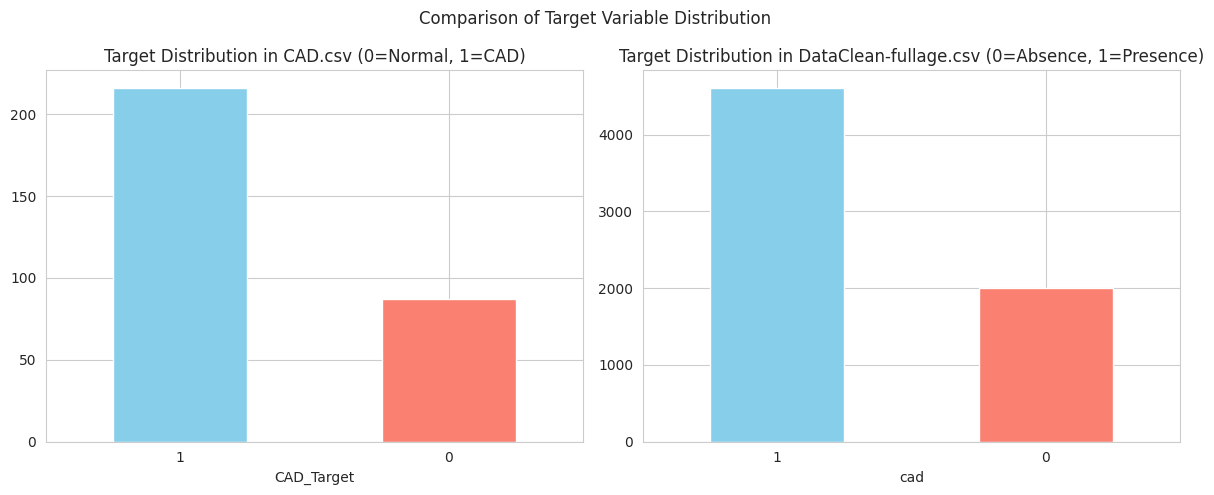

In [16]:
# 5.2. Distribution of the Target Variable (Plot)
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
df_cad['CAD_Target'].value_counts().plot(kind='bar', color=['skyblue', 'salmon'])
plt.title('Target Distribution in CAD.csv (0=Normal, 1=CAD)')
plt.xticks(rotation=0)

plt.subplot(1, 2, 2)
df_fullage['cad'].value_counts().plot(kind='bar', color=['skyblue', 'salmon'])
plt.title('Target Distribution in DataClean-fullage.csv (0=Absence, 1=Presence)')
plt.xticks(rotation=0)

plt.suptitle('Comparison of Target Variable Distribution')
plt.tight_layout()
plt.show()

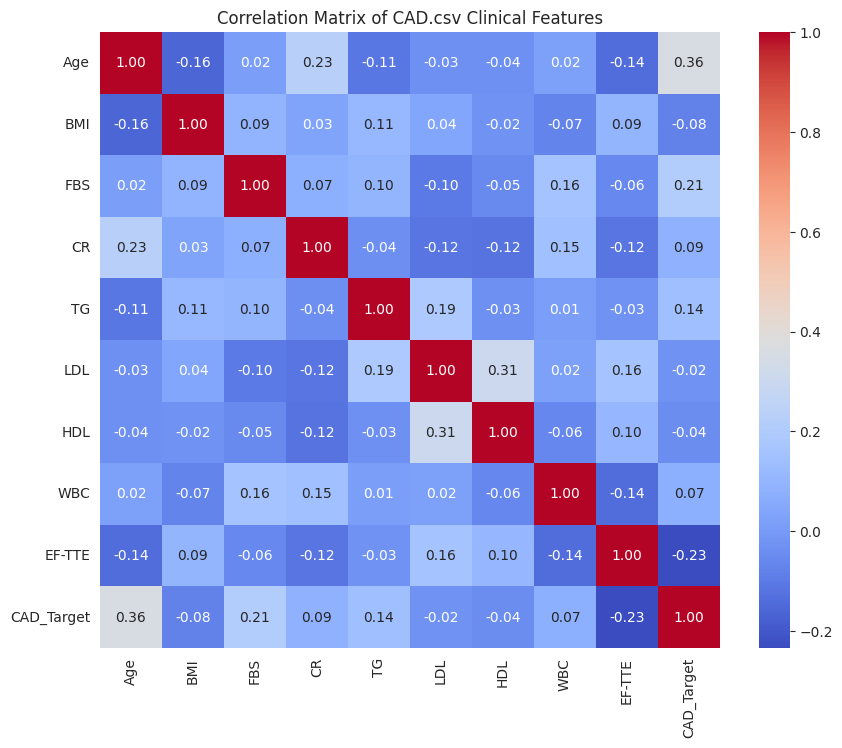

In [18]:
# 5.3. Correlation Matrix (Numerical Features - D1)
cad_num_cols = ['Age', 'BMI', 'FBS', 'CR', 'TG', 'LDL', 'HDL', 'WBC', 'EF-TTE', 'CAD_Target']
plt.figure(figsize=(10, 8))
sns.heatmap(df_cad[cad_num_cols].corr(), annot=True, fmt=".2f", cmap='coolwarm', cbar=True)
plt.title('Correlation Matrix of CAD.csv Clinical Features')
plt.show()